# Multipole expansion

Scattering of subwavelength particles is an important tool for manipulating beam profiles, enabling a range of innovative photonic applications, such as flat lenses, negative index materials, perfect dielectric absorbers, and transparent metamaterials.

In many of these applications, decomposing the scattering cross section of a particle into its multipole components is invaluable for understanding and tailoring the behavior of the structure. While Mie theory provides an analytical expression for spherical particles, it is limited to spheres. For particles of arbitrary geometries, the exact multipole expansion can be obtained by numerically solving the electric field distribution of the particle and applying the model developed in the work by Rasoul Alaee, Carsten Rockstuhl and I. Fernandez-Corbaton , entitled "An electromagnetic multipole expansion beyond the long-wavelength approximation". [DOI: https://doi.org/10.1016/j.optcom.2017.08.064](https://doi.org/10.1016/j.optcom.2017.08.064).

In this notebook, we will implement the multipole expansion for a nanosphere, allowing us to compare the results with the analytical solution using Mie theory. Nevertheless, it is straightforward to adapt this notebook for an arbitrary geometry. The model consists of a plane wave incident on a nanoparticle, with field and permittivity monitors set up to record the necessary quantities.

For more information, please refer to our [learning center](https://www.flexcompute.com/tidy3d/examples/), where you can find tutorials and examples on how to analyze [plasmonic](https://www.flexcompute.com/tidy3d/examples/notebooks/PlasmonicNanoparticle/) and [dielectric](https://www.flexcompute.com/tidy3d/examples/notebooks/Near2FarSphereRCS/) nanoparticles.

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it. 

<img src="img/multipoleExpansion.png" width="600" alt="ME">

In [1]:
import tidy3d as td
import numpy as np
import matplotlib.pyplot as plt
from tidy3d import web

import jupyter_black

jupyter_black.load()

## Simulation setup

First we will define the basic parameters.
A higher value for `n_frequencies` parameter yields a more smooth dataset at the cost of high memory consumption during the pos-processing.
Another important parameter is the `resolution`, which is defined here as the number of grid points to discretize the sphere in each direction.

In [2]:
# structure parameters
radius = 0.18

# sphere geometry object
geometry = td.Sphere(center=(0, 0, 0), radius=radius)

# define the height of the structure
structure_height = 2 * radius

# number of frequencies. A larger number will result in smoother data,
# but will consume more memory during post-processing
n_frequencies = 101


# size of the source
lx = 2 * radius
ly = 2 * radius
lz = 2 * radius

# resolution. Since we will use a mesh override around the structure,
# the default value of 10 is sufficient
min_steps_per_wvl = 10

# target spectrum
wl1 = 0.55
wl2 = 1.4

# converting to frequency
central_wl = (wl2 - wl1) / 2 + wl1
freq1 = td.C_0 / wl1
freq2 = td.C_0 / wl2
freq0 = (freq1 + freq2) / 2
fwidth = (freq1 - freq2) / 2

# frequencies to be analyzed by the field monitor
wls = np.linspace(wl2, wl1, n_frequencies)
freqs = td.C_0 / wls

# number of grid points to discretize the structure
resolution = 60

# simulation runtime
run_time = 1e-12

# simulation domain size. We add the central wavelength to ensure proper distance from the PML
Lx = central_wl + lx
Ly = Lx
Lz = central_wl + lz

# material for the structure and substrate
structure_medium = td.material_library["cSi"]["Green2008"]
substrate_material = td.Medium(permittivity=1)

# position of the source
source_z = -structure_height / 2

# electric field modulus
EModulus = 2 / (td.C_0 * td.EPSILON_0)

Next, we will define the simulation object.

Note that, for accurate results, we will set `colocate = False` for the `FieldMonitor` object. This means that the fields will be stored at their position in the Yee lattice grid, without interpolation. Since the multipole expansion is sensitive to fields at the surface, this option yields more accurate results for this analysis.

We will also use the [TFSF](https://docs.flexcompute.com/projects/tidy3d/en/stable/api/_autosummary/tidy3d.TFSF.html) source. This source injects exactly $\frac{1\text{W}}{\mu\text{m}^2}$. Hence, using the Poynting theorem, we know the relation of intensity and electric field: $I = \frac{1}{2}cn\epsilon_0|E_0|^2 = 1$, hence $|E_0|^2 = \frac{2}{cn\epsilon_0}$ where $n$ is the background medium index, which is 1 in this example.

In [3]:
# adding PMLs
boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml()
)

# TFSF source
source = td.TFSF(
    center=(geometry.center[0], geometry.center[1], -central_wl / 8),
    size=(lx, ly, lz + central_wl / 4),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    injection_axis=2,
    pol_angle=0,
    angle_theta=0,
    angle_phi=0,
)

# since the structure is smaller than the target wavelength,
# a finer mesh is required to ensure accurate results
structure_override = td.MeshOverrideStructure(
    geometry=td.Box(center=geometry.center, size=(lx, ly, lz)),
    dl=(min(lx, ly, lz) / resolution,) * 3,
)

mesh_override = [structure_override]

grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=min_steps_per_wvl, override_structures=mesh_override
)

# defining the structure objects
structure = td.Structure(
    geometry=geometry,
    medium=structure_medium,
)

substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-td.inf, -td.inf, -999),
        rmax=(td.inf, td.inf, 0 - structure_height / 2),
    ),
    medium=substrate_material,
)

# field monitor for calculating the fields
field_monitor = td.FieldMonitor(
    center=geometry.center,
    fields=["Ex", "Ey", "Ez"],
    size=(lx, ly, lz),
    freqs=freqs,
    name="fieldMon",
    colocate=False,
)

# permittivity monitor
permittivity_monitor = td.PermittivityMonitor(
    center=field_monitor.center,
    size=field_monitor.size,
    freqs=field_monitor.freqs,
    name="epsMon",
)

# creating the simulation object
sim = td.Simulation(
    size=(Lx, Ly, Lz),
    structures=[substrate, structure],
    sources=[source],
    monitors=[field_monitor, permittivity_monitor],
    run_time=run_time,
    boundary_spec=boundary_spec,
    grid_spec=grid_spec,
    shutoff=1e-7,
)

Next, we plot the simulation to assert if everything is correct, check for the estimated cost, and run the simulation. 

In [4]:
sim.plot_3d()

In [5]:
task_id = web.upload(sim, "ME")
web.estimate_cost(task_id)

08:43:14 -03 Created task 'ME' with task_id                                     
             'fdve-476628e0-3e9b-40be-b4d9-ba8bc23c3885' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=896846;https://tidy3d.simulation.cloud/workbench?taskId=fdve-476628e0-3e9b-40be-b4d9-ba8bc23c3885\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=422997;https://tidy3d.simulation.cloud/workbench?taskId=fdve-476628e0-3e9b-40be-b4d9-ba8bc23c3885\taskId]8;;\]8;id=896846;https://tidy3d.simulation.cloud/workbench?taskId=fdve-476628e0-3e9b-40be-b4d9-ba8bc23c3885\=]8;;\]8;id=520866;https://tidy3d.simulation.cloud/workbench?taskId=fdve-476628e0-3e9b-40be-b4d9-ba8bc23c3885\fdve]8;;\]8;id=896846;https://tidy3d.simulation.cloud/workbench?taskId=fdve-476628e0-3e9b-40be-b4d9-ba8bc23c3885\-476628e0-3e9]8;;\
             ]8;id=896846;https://tidy3d.simulation.cloud/workbench?taskId=fdve-476628e0-3e9b-40be-b4d9-ba8bc23c3885\b-40be-b4d9-ba8bc23c3885']8;;\.

Output()

08:43:16 -03 Maximum FlexCredit cost: 0.100. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

0.09978522811360237

In [6]:
sim_data = web.run(
    simulation=sim,
    task_name="ME_Si_Sphere",
    path="ME.hdf5",
    folder_name="MultipoleExpansion",
)

08:43:17 -03 Created task 'ME_Si_Sphere' with task_id                           
             'fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=627252;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=505127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\taskId]8;;\]8;id=627252;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\=]8;;\]8;id=565305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\fdve]8;;\]8;id=627252;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\-945d628e-3dd]8;;\
             ]8;id=627252;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\b-46c8-85ea-2b6eaebd791b']8;;\.

Output()

08:43:20 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:43:24 -03 status = preprocess

08:43:25 -03 Maximum FlexCredit cost: 0.100. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

08:43:26 -03 running solver

Output()

08:43:55 -03 early shutoff detected at 68%, exiting.

             status = postprocess

Output()

08:44:16 -03 status = success

             View simulation result at                                          
             ]8;id=205208;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=481753;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\taskId]8;;\]8;id=205208;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\=]8;;\]8;id=866595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\fdve]8;;\]8;id=205208;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\-945d628e-3dd]8;;\
             ]8;id=205208;https://tidy3d.simulation.cloud/workbench?taskId=fdve-945d628e-3ddb-46c8-85ea-2b6eaebd791b\b-46c8-85ea-2b6eaebd791b']8;;\.

Output()

08:45:17 -03 loading simulation from ME.hdf5

Now we will define the function to calculate the multipole expansion given the electric field and permittivity data. All definitions can be seen in table 2 of the [paper](https://doi.org/10.1016/j.optcom.2017.08.064).


In [7]:
def ME(Ex, Ey, Ez, x, y, z, eps_xx, eps_yy, eps_zz, freqs):
    # first we create the 4-dimensional (x,y,z,f) datasets
    X, Y, Z, Freqs = np.meshgrid(x, y, z, freqs, indexing="ij")

    # defining the angular frequencies
    omega = 2 * np.pi * freqs

    # import libraries to carry out integration and Bessel functions
    from scipy.special import spherical_jn as jn
    from scipy.integrate import trapezoid as trapz

    # function for calculating the current density
    J = lambda Ei, epsilon: 1j * (2 * np.pi * Freqs) * td.EPSILON_0 * (epsilon - 1) * Ei

    # function for calculating volume integral
    integrate = lambda Data: trapz(
        trapz(trapz(Data, x=x, axis=0), x=y, axis=0), x=z, axis=0
    )

    # defining the current densities
    Jx = J(Ex, eps_xx)
    Jy = J(Ey, eps_yy)
    Jz = J(Ez, eps_zz)

    # r vector
    r = np.sqrt(X**2 + Y**2 + Z**2)

    # wavevector
    k = omega / td.C_0

    # dot product k.r
    kr = k * r

    # dot product r.J
    rj = X * Jx + Y * Jy + Z * Jz

    # function for calculating dipole moments
    P = lambda Ji, Xi: (1j / omega) * (
        integrate(Ji * jn(0, kr))
        + ((k**2) / 2) * integrate((3 * rj * Xi - Ji * r**2) * jn(2, kr) / kr**2)
    )

    # dipole moments
    Px = P(Jx, X)
    Py = P(Jy, Y)
    Pz = P(Jz, Z)

    Ed = np.abs(Px) ** 2 + np.abs(Py) ** 2 + np.abs(Pz) ** 2

    # cross product for calculating magnetic moments
    rXJ_x = Y * Jz - Z * Jy
    rXJ_y = Z * Jx - X * Jz
    rXJ_z = X * Jy - Y * Jx

    # dipole magnetic moments
    Mx = (3 / 2) * integrate(rXJ_x * jn(1, kr) / kr)
    My = (3 / 2) * integrate(rXJ_y * jn(1, kr) / kr)
    Mz = (3 / 2) * integrate(rXJ_z * jn(1, kr) / kr)

    Md = np.abs(Mx) ** 2 + np.abs(My) ** 2 + np.abs(Mz) ** 2

    # auxiliary lists for calculating quadrupoles
    coords = [X, Y, Z]
    crossProd = [rXJ_x, rXJ_y, rXJ_z]
    Js = [Jx, Jy, Jz]

    # electric quadrupole
    Eq = np.zeros(Px.shape)
    for alpha in range(3):
        for beta in range(3):
            ra = coords[alpha]
            rb = coords[beta]
            ja = Js[alpha]
            jb = Js[beta]

            delta = 0 if alpha != beta else 1

            integrand1 = (3 * (ra * jb + rb * ja) - 2 * rj * delta) * (jn(1, kr) / kr)
            integrand2 = (
                (5 * ra * rb * rj)
                - (ra * jb + rb * ja) * r**2
                - (r**2 * rj * delta)
            ) * (jn(3, kr) / kr**3)

            Eq_ab = (3j / omega) * (
                integrate(integrand1) + (2 * k**2) * integrate(integrand2)
            )

            Eq += (1 / 120) * np.abs(k * Eq_ab) ** 2

    # magnetic quadrupole
    Mq = np.zeros(Px.shape)
    for alpha in range(3):
        for beta in range(3):
            ra = coords[alpha]
            rb = coords[beta]

            rxja = crossProd[alpha]
            rxjb = crossProd[beta]

            Mq_ab = 15 * integrate((ra * rxjb + rb * rxja) * jn(2, kr) / kr**2)
            Mq += (1 / 120) * (np.abs(k * Mq_ab) ** 2) / td.C_0**2

    # constants
    k = (2 * np.pi * freqs) / td.C_0
    const = (k**4) / (6 * np.pi * (td.EPSILON_0**2) * EModulus)

    return Ed * const, Md * const / td.C_0**2, Eq * const, Mq * const

Now we will get the needed data from the simulation results and call the ME function.
Note that using NumPy vectorization allows us to quickly compute the expansion for all frequencies at once, although it may require a large memory allocation for a significant number of frequencies. To alleviate the memory requirements, we will divide the data into frequency slices.

In [8]:
# transforming frequency to wavelength
wls = td.C_0 / freqs

# electric field and permittivity data
E = sim_data["fieldMon"]
Eps = sim_data["epsMon"]

eps_xx = Eps.eps_xx
eps_yy = Eps.eps_yy
eps_zz = Eps.eps_zz

Ex = E.Ex
Ey = E.Ey
Ez = E.Ez

eps_xx = eps_xx
eps_yy = eps_yy
eps_zz = eps_zz

# spatial components
x, y, z = eps_xx.x, eps_xx.y, eps_xx.z


Ed, Md, Eq, Mq = [], [], [], []

# calling the function

slices = 8

init = 0
step = int(np.ceil(len(freqs) / slices))
for i in range(slices):
    end = step * (1 + i)
    end = None if end > (len(freqs)) else end

    Ed_, Md_, Eq_, Mq_ = ME(
        Ex[:, :, :, init:end].values,
        Ey[:, :, :, init:end].values,
        Ez[:, :, :, init:end].values,
        x.values,
        y.values,
        z.values,
        eps_xx[:, :, :, init:end].values,
        eps_yy[:, :, :, init:end].values,
        eps_zz[:, :, :, init:end].values,
        freqs[init:end],
    )

    Ed = np.append(Ed, Ed_)
    Md = np.append(Md, Md_)
    Eq = np.append(Eq, Eq_)
    Mq = np.append(Mq, Mq_)

    init = end

    print("slice %i done" % (i + 1))

slice 1 done
slice 2 done
slice 3 done
slice 4 done
slice 5 done
slice 6 done
slice 7 done
slice 8 done


Next, we will use the open-source library [PyMieScatt](https://pymiescatt.readthedocs.io/en/latest/) to compute the analytical results based on Mie theory and compare them with the simulated results.

To install the PyMieScatt package you can uncomment the cell bellow:

In [9]:
#!pip install pymiescatt

In [10]:
from PyMieScatt.Mie import Mie_ab, MieQ

arg = np.pi * 2 * radius / wls
totalS = []

de = []
dm = []
qe = []
qm = []

for n, i in enumerate(arg):
    wl = wls[n]
    index = np.sqrt(structure_medium.eps_model(td.C_0 / wl))

    # Mie coefficients
    c = Mie_ab(index.real + 1j * index.imag, i)

    # a and b coefficients
    a, b = c

    # calculating electric and magnetic components
    idx = np.arange(len(a)) + 1
    ScattM = (2 / i**2) * (2 * idx + 1) * (0 * np.abs(a) ** 2 + np.abs(b) ** 2)
    ScattE = (2 / i**2) * (2 * idx + 1) * (np.abs(a) ** 2 + 0 * np.abs(b) ** 2)

    de.append(ScattE[0])
    dm.append(ScattM[0])
    qe.append(ScattE[1])
    qm.append(ScattM[1])

Comparing the results, we can see excellent agreement with the analytical data.

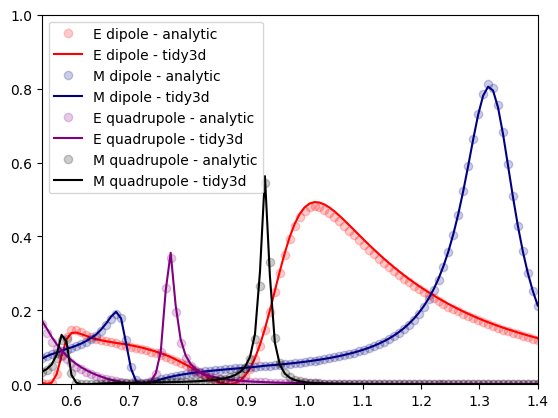

In [11]:
fig, ax = plt.subplots()

geometric_cross_section = np.pi * radius**2

ax.plot(
    wls,
    np.array(de) * geometric_cross_section,
    "o",
    alpha=0.2,
    color="red",
    label="E dipole - analytic",
)

ax.plot(wls, Ed, "-", label="E dipole - tidy3d", color="red")

ax.plot(
    wls,
    np.array(dm) * geometric_cross_section,
    "o",
    alpha=0.2,
    color="navy",
    label="M dipole - analytic",
)

ax.plot(wls, Md, "-", label="M dipole - tidy3d", color="navy")

ax.plot(
    wls,
    np.array(qe) * geometric_cross_section,
    "o",
    alpha=0.2,
    color="purple",
    label="E quadrupole - analytic",
)

ax.plot(wls, Eq, "-", label="E quadrupole - tidy3d", color="purple")

ax.plot(
    wls,
    np.array(qm) * geometric_cross_section,
    "o",
    alpha=0.2,
    color="black",
    label="M quadrupole - analytic",
)

ax.plot(wls, Mq, "-", label="M quadrupole - tidy3d", color="black")

ax.set_xlim(0.55, 1.4)
ax.set_ylim(0, 1)
ax.legend()
plt.show()

### Error analysis

Since the results are sensitive to the discretization, we show the mean error of the multipole expansion by comparing the analytical results for different values of the `resolution` parameter.We observe an exponential improvement that reaches a plateau at a resolution value of 60.

The color map shows the Flexcredit cost for each simulation, indicating that an accurate simulation can be run with approximately 0.15 Flexcredits. Due to memory restrictions, these tests were performed with only 81 frequency points.

<img src="img/errorAnalysisME.png" width="600" alt="Error analysis">

### Ploting the fields

We can now rerun the simulation with a planar monitor to record the field profile for each multipole component.

In [12]:
# frequency value for each multipole component
ed_freq = td.C_0 / wls[np.argmax(Ed)]
md_freq = td.C_0 / wls[np.argmax(Md)]
eq_freq = td.C_0 / wls[np.argmax(Eq)]
mq_freq = td.C_0 / wls[np.argmax(Mq)]

xyMonitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(2 * radius, 2 * radius, 0),
    freqs=[ed_freq, md_freq, eq_freq, mq_freq],
    name="xyFieldMon",
)


sim2 = sim.updated_copy(
    monitors=[
        xyMonitor,
    ]
)

sim_data2 = web.run(
    simulation=sim2,
    task_name="ME_Si_Sphere_fields",
    path="ME_fields.hdf5",
    folder_name="MultipoleExpansion",
)

08:47:21 -03 Created task 'ME_Si_Sphere_fields' with task_id                    
             'fdve-2d7c38e2-3113-4169-be20-8411d3644e39' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=568607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=545125;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\taskId]8;;\]8;id=568607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\=]8;;\]8;id=823659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\fdve]8;;\]8;id=568607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\-2d7c38e2-311]8;;\
             ]8;id=568607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\3-4169-be20-8411d3644e39']8;;\.

Output()

08:47:23 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:47:34 -03 status = preprocess

08:47:35 -03 Maximum FlexCredit cost: 0.056. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

08:47:36 -03 running solver

Output()

08:48:06 -03 early shutoff detected at 68%, exiting.

             status = postprocess

Output()

             status = success

08:48:07 -03 View simulation result at                                          
             ]8;id=855805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=974802;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\taskId]8;;\]8;id=855805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\=]8;;\]8;id=912465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\fdve]8;;\]8;id=855805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\-2d7c38e2-311]8;;\
             ]8;id=855805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d7c38e2-3113-4169-be20-8411d3644e39\3-4169-be20-8411d3644e39']8;;\.

Output()

08:48:12 -03 loading simulation from ME_fields.hdf5

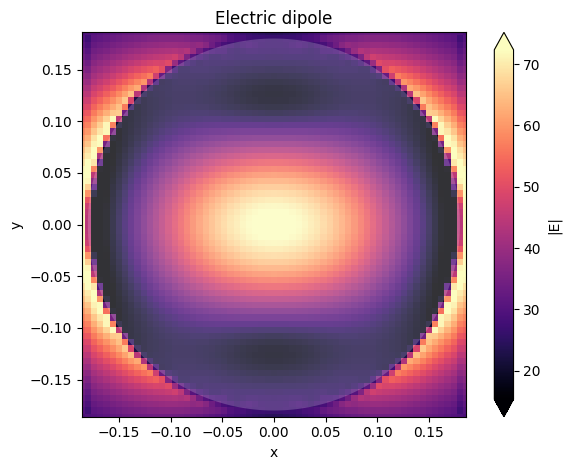

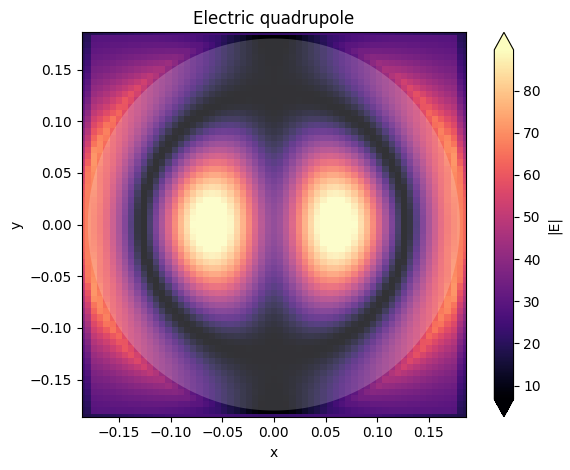

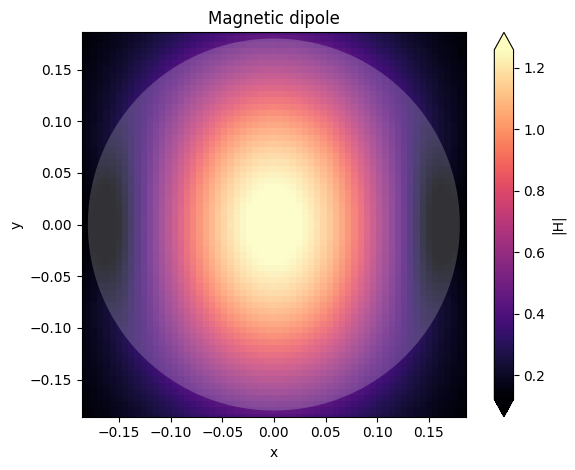

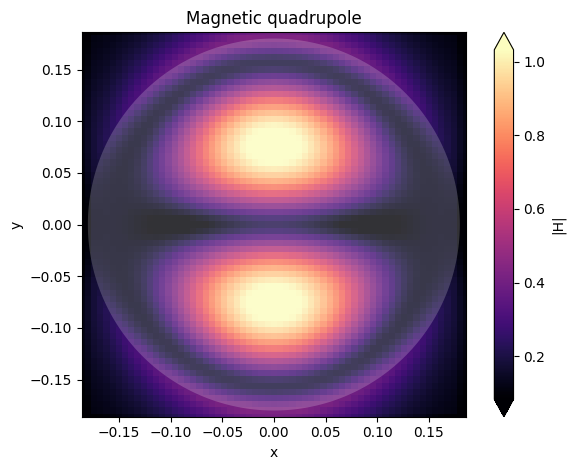

In [13]:
ax = sim_data2.plot_field("xyFieldMon", "E", "abs", f=ed_freq)
ax.set_title("Electric dipole")

ax = sim_data2.plot_field("xyFieldMon", "E", "abs", f=eq_freq)
ax.set_title("Electric quadrupole")

ax = sim_data2.plot_field("xyFieldMon", "H", "abs", f=md_freq)
ax.set_title("Magnetic dipole")

ax = sim_data2.plot_field("xyFieldMon", "H", "abs", f=mq_freq)
ax.set_title("Magnetic quadrupole")

plt.show()